In [1]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import urllib.request
import networkx as nx 
import seaborn as sns
import pandas as pd
import numpy as np
import string
import scipy
import json
import nltk
import ast
import re

from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from urllib.parse import quote
from enum import Enum
from community import community_louvain
from fa2 import ForceAtlas2
from infomap import Infomap

nltk.download('stopwords')
sns.set_theme()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mikkel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Get Harry Potter characters from Wiki
(Only necessary first time for download else use csv)  

In [2]:
males   = []
females = []

# Run through the alphabet in order to get all characters in alphabetical order from wiki
for l in list(string.ascii_uppercase):
  # Guery the url with the current iterated letter from the alphabet
  query = "https://harrypotter.fandom.com/wiki/Category:Males?from=" + l
  query2 = "https://harrypotter.fandom.com/wiki/Category:Females?from=" + l
  
  # Get response for Male and Females and read data
  response_m = urllib.request.urlopen(query)
  response_f = urllib.request.urlopen(query2)

  raw_data_m = response_m.read().decode('utf-8')
  raw_data_f = response_f.read().decode('utf-8')

  # Scrape a specific section of the response to get names
  reg_names = re.findall('="/wiki/[\w\s]*"', raw_data_m)
  names = list(set([name.replace('="/wiki/', '').replace("\"", "") for name in reg_names]))
  males = males + names
  
  reg_names = re.findall('="/wiki/[\w\s]*"', raw_data_f)
  names = list(set([name.replace('="/wiki/', '').replace("\"", "") for name in reg_names]))
  females = females + names

In [20]:
# Convert to dataframes
dict_m = {'Males': males}
df = pd.DataFrame(dict_m)
df.to_csv('harry_potter_males.csv')

dict_f = {'Females': females}
df = pd.DataFrame(dict_f)
df.to_csv('harry_potter_females.csv')

## Get Character information

In [4]:
# Character names
df_males = pd.read_csv("harry_potter_males.csv")
df_females = pd.read_csv("harry_potter_females.csv")

# Reading local csv introduces a new index column which is unwanted
df_females.columns = ["index","Character"]
df_males.columns = ["index","Character"]

df_females = df_females.drop('index',axis=1)
df_males = df_males.drop('index',axis=1)

# Add Gender attribute
df_females["Gender"] = "Female"
df_males["Gender"] = "Male"

# Combine dataframes and introduce Story attribute
df_characters = pd.concat([df_females, df_males], ignore_index=True)
#df_characters["Story"] = ""

#df_characters.drop_duplicates(subset="Character", keep=False, inplace=True)

In [5]:
# Create base for request
baseurl = "https://harrypotter.fandom.com/api.php?"
action = "action=query"
title = "titles="
content = "prop=revisions&rvprop=content"
dataformat = "format=json"

In [6]:
def getResponse(link):
  # Replace whitespace and unicode
  encoded_link = quote(link.replace(" ", "_"))
  specific_title = title + encoded_link
  query = "%s%s&%s&%s&%s" % (baseurl, action, specific_title, content, dataformat)
  
  response = urllib.request.urlopen(query)
  raw_data = response.read()

  return json.loads(raw_data)

In [7]:
df = pd.DataFrame(columns = ['Character', 'Gender', 'Story', 'References', 'Housing'])

for (character, gender) in df_characters[['Character', 'Gender']].values:
  json_data = getResponse(character)
  
  # Each hero has a unqie page id (or sumthin i dunno) use it to access data
  index = list(json_data['query']['pages'])[0]
  
  # Sort through herores where wiki page couldnt be found
  if index == "-1":
    print("No data for such character:", character)
  else:
    # Check if character has been changed to another location (Found in their "story")
    if "#REDIRECT" in json_data['query']['pages'][index]['revisions'][0]['*']:
      # Extract new location
      redirect = re.findall('#REDIRECT\s*\[\[[^\]\]]*\]\]', json_data['query']['pages'][index]['revisions'][0]['*'])[0]
      new_wikilink = redirect.replace('#REDIRECT', '').replace('[', '').replace(']', '').strip()
      # Get new data
      json_data = getResponse(new_wikilink)
      # Set new index
      index = list(json_data['query']['pages'])[0]
    
    story = json_data['query']['pages'][index]['revisions'][0]['*']

    # Find all occurences of "[[...]]"
    regex_ref = re.findall('\[\[[^\]\]]*\]\]', story)
    # Remove "[" and "]" from elements in list
    regex_ref = [r.replace('[', '').replace(']', '') for r in regex_ref]
    # Remove duplicates
    references = list(dict.fromkeys(regex_ref))
    
    # Remove all references not prominent in the superhero list
    references = [ref for ref in references if len(df_characters[df_characters['Character'] == ref.replace(' ', '_')])] 

    # Find housing of characters
    regex_housing = re.findall('\|house = \[\[\w*\]\]', story)
    housing = regex_housing[0].replace('|house = [[', '').replace(']]', '') if regex_housing else None

    df_length = len(df)
    df.loc[df_length] = [character, gender, story, references, housing]

No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_Sitemap
No data for such character: Local_

In [8]:
# Save df as csv
# df.to_csv('harry_potter_new_df.csv')

## Sentiment Analysis on Wiki and Book information

### Analysis based on Wiki information


In [24]:
df = pd.read_csv("harry_potter_new_df.csv") #Load datframe containg the Harry Potter data
df = df.drop('Unnamed: 0',axis = 1) #Drop redundant indexing column 

In [25]:
#Seperate the characters story from the other info given in the story column, if character has no story "None" is entered as story
df["Story_only"] = [info.split('\n}}')[1] if (len(info.split('\n}}')) > 1) else 'None' for info in df["Story"]]

#Find all words in the text using regular expression
df["Story_only"] = [re.findall('\w+',x) for x in df["Story_only"]]

In [26]:
#Load sentiment dataframe and extract interesting columns to farm a dicionary of words and their sentiment score
df_sentiment = pd.read_csv('Sentiment_scores.txt', sep='\t',engine='python')
df_word_and_scores = df_sentiment[['word', 'happiness_average']].copy()
sentiment_dict = dict(zip(df_word_and_scores.word, df_word_and_scores.happiness_average))

In [27]:
#Get sentiment eligible tokens from story and store them by matching story against sentiment word list
st_words = stopwords.words('english')
sentiment_eligible_tokens = [[word for word in story if word in list(sentiment_dict.keys()) and word not in st_words] for story in df["Story_only"] ]

In [28]:
#Calculate the average sentiment for a characters story
df["Sentiment"] = [(sum([sentiment_dict[token] for token in story])/len(story)) if (len(story) > 0) else 0 for story in sentiment_eligible_tokens]

In [29]:
#Export dataframe for further analysis
# df.to_pickle("Sentiment_for_characters.pkl") 

#### Compare differnces in happiness between men and women

In [30]:
#Filter out characters who do not have sentiment elligeble tokens assigned to them and split the filtering into gender lists.
cleaned_df = df[df["Sentiment"] >0]
females = cleaned_df["Sentiment"][cleaned_df["Gender"] == "Female"]
males = cleaned_df["Sentiment"][cleaned_df["Gender"] == "Male"]

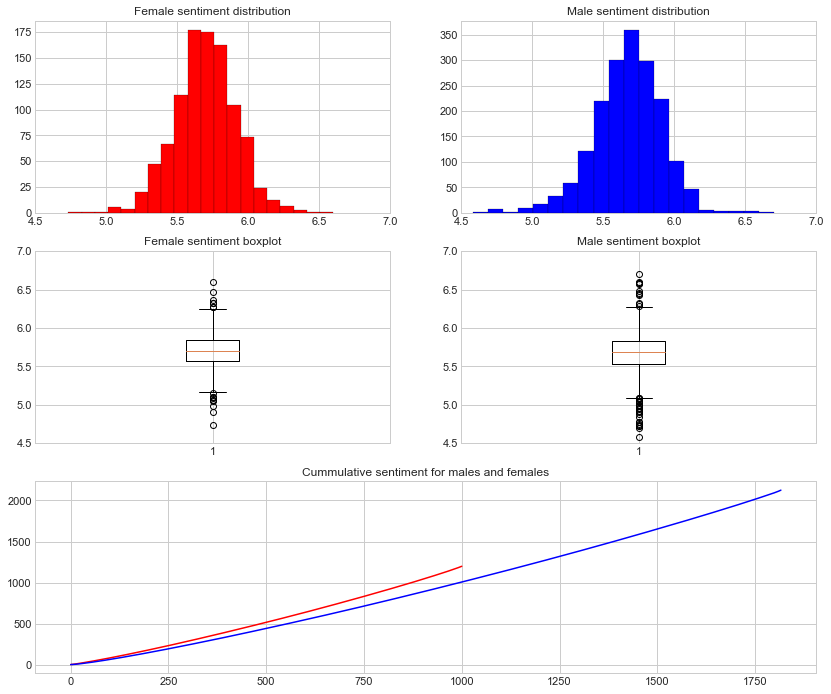

In [31]:
#Plot Histogram, boxplot and cummulative curves for the sentiment of the genders
import numpy as np
plt.figure(figsize=(14,12)) 
plt.style.use('seaborn-whitegrid') 

plt.subplot(3, 2, 1)
plt.title("Female sentiment distribution")
plt.xlim([4.5, 7])
n, bins, patches=plt.hist(females,bins=20, facecolor = 'red', edgecolor='black', linewidth=0.2)

plt.subplot(3, 2, 2)
plt.title("Male sentiment distribution")
plt.xlim([4.5, 7])
n, bins, patches=plt.hist(males,bins=20, facecolor = 'blue', edgecolor='black', linewidth=0.2)

plt.subplot(3, 2, 3)
plt.title("Female sentiment boxplot")
plt.ylim([4.5, 7])
plt.boxplot(females)

plt.subplot(3, 2, 4)
plt.title("Male sentiment boxplot")
plt.ylim([4.5, 7])

plt.boxplot(males)

plt.subplot(3, 2, (5, 6))
plt.title("Cummulative sentiment for males and females")
plt.plot(range(len(females)), np.cumsum(sorted([x - 4.5 for x in females])), color="red", label="Females")
plt.plot(range(len(males)), np.cumsum(sorted([x - 4.5 for x in males])), color="blue", label="Males")
plt.show()

No significant difference in the sentiment of gender

#### Compare happiness between communities

In [32]:
#Create sentiment groupings for the Hogwarts houses.
Hufflepuff = cleaned_df["Sentiment"][cleaned_df["Housing"] == "Hufflepuff"]
Ravenclaw = cleaned_df["Sentiment"][cleaned_df["Housing"] == "Ravenclaw"]
Gryffindor = cleaned_df["Sentiment"][cleaned_df["Housing"] == "Gryffindor"]
Slytherin = cleaned_df["Sentiment"][cleaned_df["Housing"] == "Slytherin"]
no_house = cleaned_df["Sentiment"][cleaned_df["Housing"].isnull()]

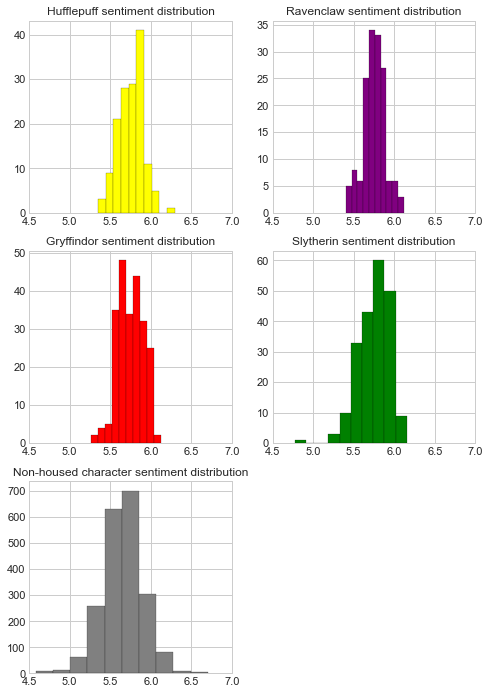

In [33]:
#Plot histograms for the sentiment of the Hogwarts houses
plt.figure(figsize=(8,12)) 
plt.style.use('seaborn-whitegrid') 

plt.subplot(3, 2, 1)
plt.title("Hufflepuff sentiment distribution")
plt.xlim([4.5, 7])
n, bins, patches=plt.hist(Hufflepuff,bins=10, facecolor = 'yellow', edgecolor='black', linewidth=0.2)

plt.subplot(3, 2, 2)
plt.title("Ravenclaw sentiment distribution")
plt.xlim([4.5, 7])
n, bins, patches=plt.hist(Ravenclaw,bins=10, facecolor = 'purple', edgecolor='black', linewidth=0.2)

plt.subplot(3, 2, 3)
plt.title("Gryffindor sentiment distribution")
plt.xlim([4.5, 7])
n, bins, patches=plt.hist(Gryffindor,bins=10, facecolor = 'red', edgecolor='black', linewidth=0.2)

plt.subplot(3, 2, 4)
plt.title("Slytherin sentiment distribution")
plt.xlim([4.5, 7])
n, bins, patches=plt.hist(Slytherin,bins=10, facecolor = 'green', edgecolor='black', linewidth=0.2)

plt.subplot(3, 2, 5)
plt.title("Non-housed character sentiment distribution")
plt.xlim([4.5, 7])
n, bins, patches=plt.hist(no_house,bins=10, facecolor = 'grey', edgecolor='black', linewidth=0.2)
plt.show()

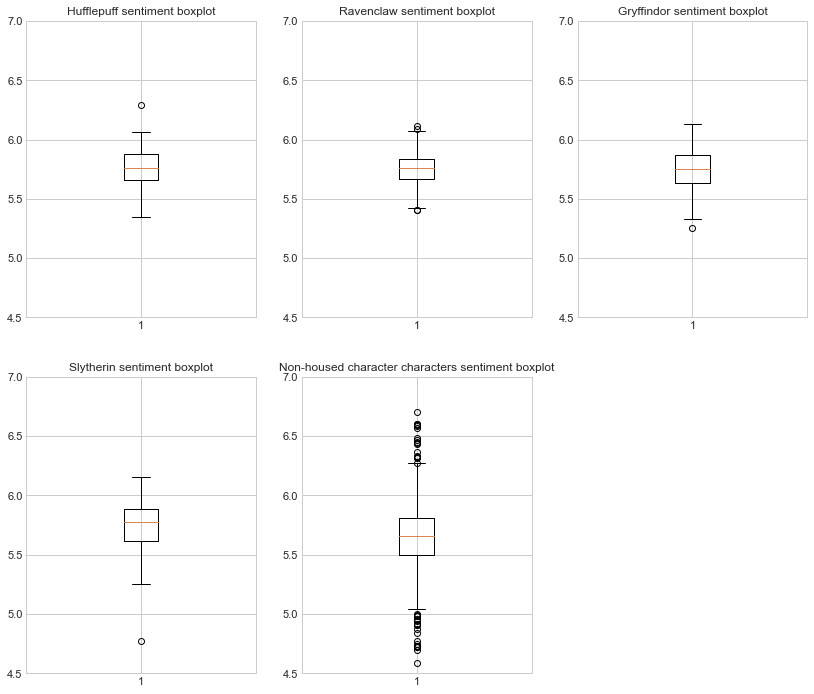

In [34]:
#Plot Boxplots for the sentiment of the Hogwarts houses
plt.figure(figsize=(14,12)) 
plt.style.use('seaborn-whitegrid') 

plt.subplot(2, 3, 1)
plt.title("Hufflepuff sentiment boxplot")
plt.ylim([4.5, 7])
plt.boxplot(Hufflepuff)

plt.subplot(2, 3, 2)
plt.title("Ravenclaw sentiment boxplot")
plt.ylim([4.5, 7])
plt.boxplot(Ravenclaw)

plt.subplot(2, 3, 3)
plt.title("Gryffindor sentiment boxplot")
plt.ylim([4.5, 7])
plt.boxplot(Gryffindor)

plt.subplot(2, 3, 4)
plt.title("Slytherin sentiment boxplot")
plt.ylim([4.5, 7])
plt.boxplot(Slytherin)

plt.subplot(2, 3, 5)
plt.title("Non-housed character characters sentiment boxplot")
plt.ylim([4.5, 7])
plt.boxplot(no_house)
plt.show()

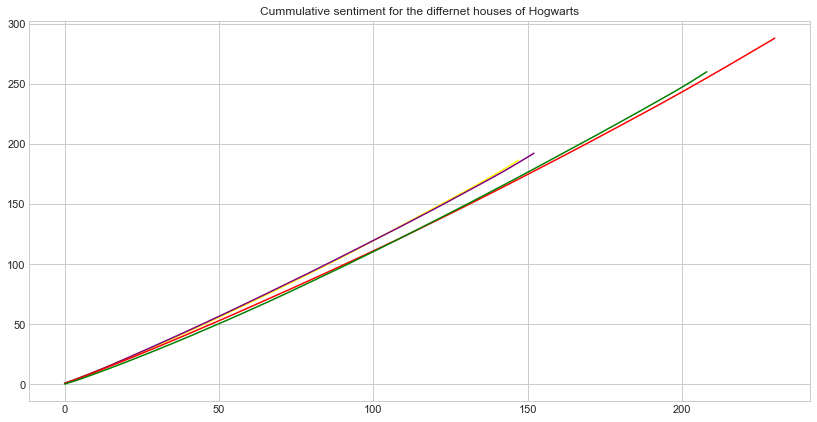

In [51]:
#Plot cummulative curves for the sentiment of the Hogwarts houses
plt.figure(figsize=(14,7)) 
plt.style.use('seaborn-whitegrid') 
plt.title("Cummulative sentiment for the differnet houses of Hogwarts")
plt.plot(range(len(Hufflepuff)), np.cumsum(sorted([x - 4.5 for x in Hufflepuff])), color="yellow", label="Hufflepuff")
plt.plot(range(len(Ravenclaw)), np.cumsum(sorted([x - 4.5 for x in Ravenclaw])), color="purple", label="Ravenclaw")
plt.plot(range(len(Gryffindor)), np.cumsum(sorted([x - 4.5 for x in Gryffindor])), color="red", label="Gryffindor")
plt.plot(range(len(Slytherin)), np.cumsum(sorted([x - 4.5 for x in Slytherin])), color="green", label="Slytherin")
#plt.plot(range(len(no_house)), np.cumsum(sorted([x - 4.5 for x in no_house])), color="black", label="no_house")
plt.show()

#### Compare connectivity

In [36]:
df = pd.read_pickle("Sentiment_for_characters.pkl")

# References are read as a string looking like a list convert that back to list
df['References'] = [[r.replace(' ', '_') for r in ast.literal_eval(stringRef)] for stringRef in df['References']]

In [37]:
G = nx.Graph()

# Add characters as nodes
G.add_nodes_from(df["Character"])
# Add references as edges
for c,r in df[["Character","References"]].values:
     for single in r:
        if single != c and single in df["Character"].values:
            G.add_edge(c,single)

In [38]:
# Get a dict of character and degree
d = dict(G.degree())
# Sort descending based on degree
sorted_list = list({k: d[k] for k in sorted(d, key=d.get, reverse=True)}.keys())

# Select a range of top and bottom characters based on degree
top_d = sorted_list[:int(len(df)*0.33)]
bot_d = sorted_list[int(len(df)*0.5) : len(df) - int(len(df)*0.33)]

df_top = df[df['Character'].isin(top_d)]
df_bot = df[df['Character'].isin(bot_d)]

# Get mean
top_avg = df_top['Sentiment'].mean()
bot_avg = df_bot['Sentiment'].mean()

correlation = scipy.stats.pearsonr([d[c] for c in top_d], df_top.sort_values(by=['Character'])['Sentiment'])

print("Mean sentiment of top 30% most connected charaters:\t", top_avg)
print("Mean sentiment of least connected charaters:\t\t", bot_avg)
print("Correlation r-value: ", correlation[0])

Mean sentiment of top 30% most connected charaters:	 5.305688086299589
Mean sentiment of least connected charaters:		 5.302697742818556
Correlation r-value:  0.006487075981866807


In [39]:
# Calculate centrality of network
centrality = nx.degree_centrality(G)
{k: centrality[k] for k in sorted(centrality, key=centrality.get, reverse=True)}

{'Harry_Potter': 0.2054073033707865,
 'Albus_Dumbledore': 0.10077247191011236,
 'Hermione_Granger': 0.09094101123595505,
 'Ronald_Weasley': 0.06390449438202248,
 'Severus_Snape': 0.06214887640449438,
 'Rubeus_Hagrid': 0.05898876404494382,
 'Sirius_Black': 0.05512640449438202,
 'Draco_Malfoy': 0.05266853932584269,
 'Minerva_McGonagall': 0.05196629213483146,
 'Dolores_Umbridge': 0.04985955056179775,
 'Tom_Riddle': 0.047752808988764044,
 'Neville_Longbottom': 0.04669943820224719,
 'Horace_Slughorn': 0.04178370786516854,
 'Arthur_Weasley': 0.04143258426966292,
 'George_Weasley': 0.03651685393258427,
 'Nymphadora_Tonks': 0.03476123595505618,
 'Bellatrix_Lestrange': 0.034058988764044944,
 'Ginevra_Weasley': 0.03230337078651685,
 'Alastor_Moody': 0.03230337078651685,
 'Luna_Lovegood': 0.03125,
 'Lucius_Malfoy': 0.03089887640449438,
 'Remus_Lupin': 0.030547752808988762,
 'Cedric_Diggory': 0.030196629213483143,
 'Fred_Weasley': 0.029845505617977528,
 'Molly_Weasley': 0.02914325842696629,
 'Argu

### Analysis based on Books

In [40]:
df_c = pd.read_pickle("Sentiment_for_characters.pkl")

In [41]:
base_link = "https://raw.githubusercontent.com/prakhar21/whiteboard/master/nbviewer/notebooks/data/harrypotter/"

# Book titles
class Books(Enum): 
    TITLE1 = "The Philosopher\'s Stone"
    TITLE2 = "The Chamber of Secrets"
    TITLE3 = "The Prisoner of Azkaban"
    TITLE4 = "The Goblet of Fire"
    TITLE5 = "The Order of the Phoenix"
    TITLE6 = "The Half Blood Prince"
    TITLE7 = "The Deathly Hallows"

book_story = {}
book_characters = {}
#For each of the books
for i, book in enumerate(Books):
    
  #The first 4 lines in the loop accesses the designated book in the loop iteration and stores the text in the raw_data variable
  bookFormat = "Book %s - %s.txt" % (i+1, book.value)
  encoded_query = base_link + quote(bookFormat)
  response = urllib.request.urlopen(encoded_query)
  raw_data = response.read().decode('utf-8')

  # Replace page footer - e.g. "Page | 1 Harry Potter and the Philosophers Stone - J.K. Rowling"
  raw_data = raw_data.replace("page | ", "").replace("harry potter and " + book.value.lower().replace("\'", "") + " - j.k. rowling", "")
  
  # Remove all newline commands from the text
  words=raw_data.strip().replace('\n', '')
    
  #split the book into sentences with the NLTK sent_tokenize tokenizer.
  book_story[book.value] = sent_tokenize(words)
  listb = []

  #For each character in the wiki character dataframe 
  for c in df_c["Character"]:
    #If character has a split name, such as Albus_Dumbledore and the name is not 'Unidentified', then check if the name is present
    #in the book. If it is, then append that name to listb which is the list storing all names present in the current book.
    if len(c.split("_")) > 1 and c.split("_")[0] != "Unidentified" :
      if c.split("_")[0] in words:
        listb.append(c.split("_")[0])
        
    #else if name is not a split names and is not 'Unidentified, just append the name to listb if the name is present in the current book'
    elif (len(c.split("_")) < 1 and c != "Unidentified"):
      if c in words:
        listb.append(c)
        
  #When all characters in the dataframe has been iterated through, listb is stored in the book_character dict under the book key as a value 
  book_characters[book.value] = listb

In [42]:
#Load sentiment dataframe and extract interesting columns to farm a dicionary of words and their sentiment score
df_sentiment = pd.read_csv('Sentiment_scores.txt', sep='\t',engine='python')
df_word_and_scores = df_sentiment[['word', 'happiness_average']].copy()
sentiment_dict = dict(zip(df_word_and_scores.word, df_word_and_scores.happiness_average))

In [43]:
#Get sentiment eligible tokens from story and store them by matching story against sentiment word list
sentiment_eligible_tokens = [[word for word in story if word in list(sentiment_dict.keys())] for story in book_story.values() ]

In [45]:
#Load the NLTK stopwords corpus and store the english stopword list in st_words
from nltk.corpus import stopwords
st_words = stopwords.words('english')
#Load sentiment dataset and extract interesting columns to farm a dicionary of words and their sentiment score
df_sentiment = pd.read_csv('Sentiment_scores.txt', sep='\t',engine='python')
df_word_and_scores = df_sentiment[['word', 'happiness_average']].copy()
sentiment_dict = dict(zip(df_word_and_scores.word, df_word_and_scores.happiness_average))

In [46]:
#regex for finding the whole word in a text and not just match a sequence of characters, such that 'able' doesn't get found when serching for 'table' for instance
#https://stackoverflow.com/questions/5319922/check-if-a-word-is-in-a-string-in-python - answer from Hugh Bothwell
def findWholeWord(w):
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

In [47]:
#Function for finding the sentiment and sentences for characters in a book
def get_character_sentiment_for_book(book):
    
    #Store all sentences a character is in, in a dictionary where the key is 'character'_sents and values are all the sentences with tha character
    character_sents = []
    char_sents = {}
    for c in book_characters[book]:
        name = c+"_sents"
        name = []
        for sent in book_story[book]:
            if findWholeWord(c)(sent):
                name.append(sent)
        char_sents[c+"_sents"] = name

    #Find all non-stopwords elligeble for sentiment analysis by matching the sentence words to the sentiment dataset
    char_elligeble = {}
    for character in char_sents.keys():
        elligeble = []
        for sent in char_sents[character]:
            sent = re.findall('\w+',sent) 
            for word in sent:
                if word in list(sentiment_dict.keys()) and word not in st_words:
                    elligeble.append(word)
        char_elligeble[character]=elligeble
    
    #Calculate the sentiment for each sentence a characters has and sum them to a combined score
    score = []
    has = []
    for character in char_elligeble.keys():
        scores = []
        for token in char_elligeble[character]:
            scores.append(sentiment_dict[token])
        if len(scores) > 0:
            score.append(sum(scores)/len(scores))
            has.append(character.split("_")[0])
    df_sentiment = pd.DataFrame(has)
    df_sentiment["Scores"]=score
    
    #return a dataframe containing the characters of the book and their overall sentiment. As well as a dict with the cahracter sentences  
    return df_sentiment, char_sents

In [48]:
#Get sentiment values for each character, as well as the sentences in which the characters are presented, in all of the books, 
#(seperated by book), using the get_character_sentiment_for_book function.
books = ["The Philosopher\'s Stone","The Chamber of Secrets","The Prisoner of Azkaban","The Goblet of Fire","The Order of the Phoenix","The Half Blood Prince","The Deathly Hallows"]
sent4books = []
character_sentences = []
for book in books:
    sentiment_scores, character_sents = get_character_sentiment_for_book(book)
    sent4books.append(sentiment_scores)
    character_sentences.append(character_sents)

In [49]:
#Find mean, 90th and 10th percentile for each book and store them in lists
lmean = []
l90percentile = []
l10percentile = []

for book_scores in sent4books:
    lmean.append(sum(book_scores["Scores"])/len(book_scores["Scores"]))
    l90percentile.append(np.percentile(book_scores["Scores"], 90))
    l10percentile.append(np.percentile(book_scores["Scores"], 10))

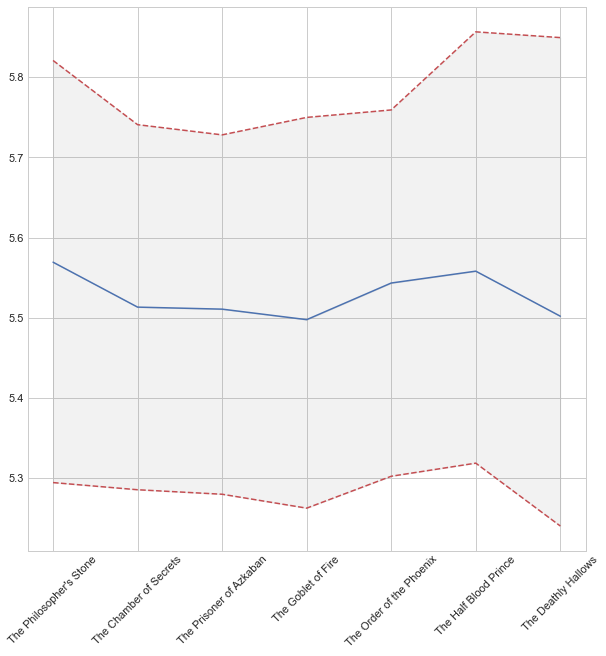

In [54]:
#Plot the sentiment for characters of the books, so that the sentiment becomes a curve over the course of time.
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(10,10)) 
plt.style.use('seaborn-whitegrid') 
x = [*range(0, len(sent4books))]
plt.plot(l90percentile, linestyle='dashed', color = 'r')
plt.plot(l10percentile, linestyle='dashed', color = 'r')
plt.plot(lmean, color = 'b')
plt.fill_between(x,l90percentile, lmean, color='gray',
                 alpha=0.1)
plt.fill_between(x,l10percentile, lmean, color='gray',
                 alpha=0.1)
plt.xticks(x, books, rotation =45)
plt.show()

## Graphing

In [55]:
df = pd.read_pickle("Sentiment_for_characters.pkl")

# References are read as a string looking like a list convert that back to list
df['References'] = [[r.replace(' ', '_') for r in ast.literal_eval(stringRef)] for stringRef in df['References']]

In [56]:
def plotGraph(dataframe, title=None, pos=None, withLabels=False, numLabels=10):
  g = nx.Graph()

  # Add characters as nodes
  g.add_nodes_from(dataframe["Character"], Housing=dataframe['Housing'], Gender=dataframe['Gender'], Sentiment=df['Sentiment'])
  # Add references as edges
  for c,r in dataframe[["Character","References"]].values:
    for single in r:
      # Check if in overall dataframe
      if single != c and single in df["Character"].values:
        g.add_edge(c,single)
  
  forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1,

                        # Performance
                        jitterTolerance=0.1,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.5,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=5.0,
                        strongGravityMode=False,
                        gravity=50,

                        # Log
                        verbose=True)
  pos = forceatlas2.forceatlas2_networkx_layout(g, pos=pos, iterations=2000)

  d = dict(g.degree())
  plt.figure(1, figsize=(20,12)) 

  # Nodes
  housing = [df[df['Character'] == c]['Housing'].values for c in g.nodes.keys()]
  color_map = ["#740001" if h == 'Gryffindor' else "#ECB939" if h == 'Hufflepuff' else "#0E1A40" if h == 'Ravenclaw' else "#1A472A" if h == 'Slytherin' else "#AEAEAE" for h in housing]
  edge_color = ["#520001" if df[df['Character'] == h2]['Housing'].values == 'Gryffindor' else "#9E7715" if df[df['Character'] == h2]['Housing'].values == 'Hufflepuff' else "#0E309C" if df[df['Character'] == h2]['Housing'].values == 'Ravenclaw' else "#118A3C" if df[df['Character'] == h2]['Housing'].values == 'Slytherin' else "#5C5B5B" for h1,h2 in g.edges]
  node_size = [v * 10 for v in d.values()]

  nx.draw_networkx_nodes(g, node_color=color_map, pos=pos, node_size=node_size)
  nx.draw_networkx_edges(g, pos, edge_color=edge_color, alpha=0.15)

  if (withLabels):
    most_connected = list({k: d[k] for k in sorted(d, key=d.get, reverse=True)}.keys())[:numLabels]
    nx.draw_networkx_labels(g, pos, labels={k: k for k in most_connected})
  
  if title is None:
    plt.title("The ForceAtlas representation of the Character Network.")
  else:
    plt.title(title)

  plt.show()

### Plotting the universe

In [57]:
G = nx.Graph()

# Add characters as nodes
G.add_nodes_from(df["Character"], Housing=df['Housing'], Gender=df['Gender'], Sentiment=df['Sentiment'])
# Add references as edges
for c,r in df[["Character","References"]].values:
     for single in r:
        if single != c and single in df["Character"].values:
            G.add_edge(c,single)

In [58]:
pos = nx.kamada_kawai_layout(G)

In [59]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1,

                        # Performance
                        jitterTolerance=0.1,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=0.5,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1,
                        strongGravityMode=False,
                        gravity=1,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=pos, iterations=200)
# positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=200)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:38<00:00,  5.21it/s]

BarnesHut Approximation  took  4.45  seconds
Repulsion forces  took  33.39  seconds
Gravitational forces  took  0.06  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.22  seconds


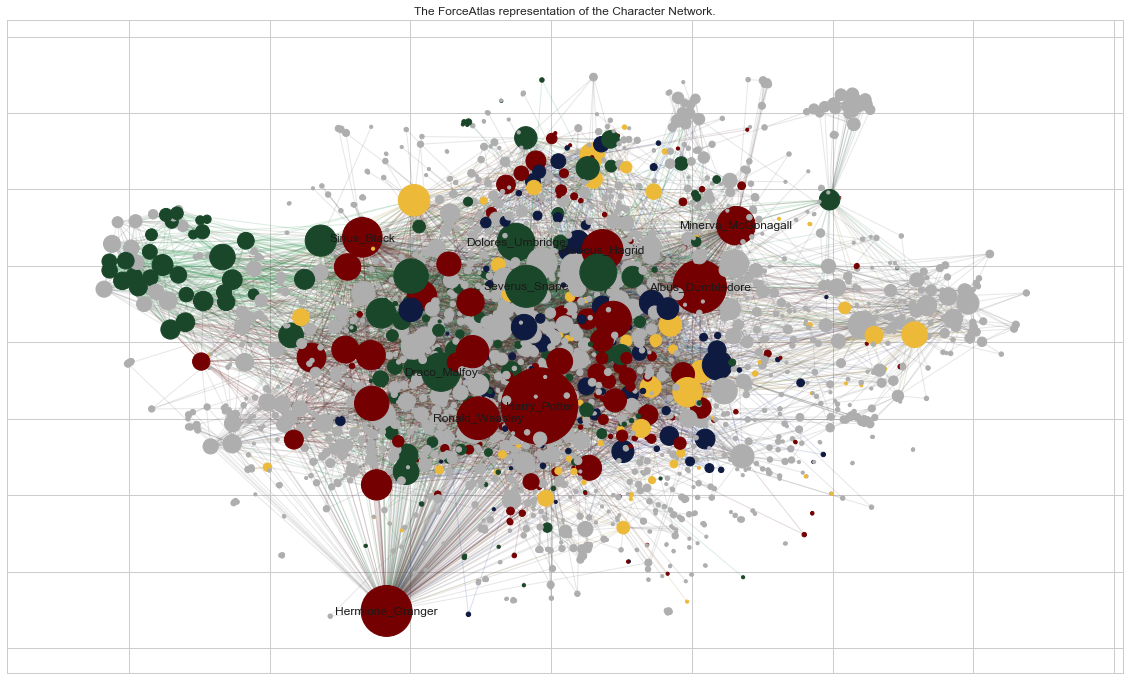

In [60]:
d = dict(G.degree())
plt.figure(1, figsize=(20,12)) 

# Nodes
housing = [df[df['Character'] == c]['Housing'].values for c in G.nodes.keys()]
color_map = ["#740001" if h == 'Gryffindor' else "#ECB939" if h == 'Hufflepuff' else "#0E1A40" if h == 'Ravenclaw' else "#1A472A" if h == 'Slytherin' else "#AEAEAE" for h in housing]
edge_color = ["#520001" if df[df['Character'] == h2]['Housing'].values == 'Gryffindor' else "#9E7715" if df[df['Character'] == h2]['Housing'].values == 'Hufflepuff' else "#0E309C" if df[df['Character'] == h2]['Housing'].values == 'Ravenclaw' else "#118A3C" if df[df['Character'] == h2]['Housing'].values == 'Slytherin' else "#5C5B5B" for h1,h2 in G.edges]
node_size = [v * 10 for v in d.values()]

nx.draw_networkx_nodes(G, node_color=color_map, pos=positions, node_size=node_size)
nx.draw_networkx_edges(G, positions, edge_color=edge_color, alpha=0.15)

most_connected = list({k: d[k] for k in sorted(d, key=d.get, reverse=True)}.keys())[:10]
nx.draw_networkx_labels(G, positions, labels={k: k for k in most_connected})

# most_connected = list({k: d[k] for k in sorted(d, key=d.get, reverse=True)}.keys())[:50]
# Draw node labels
# for i,n in enumerate(G.nodes()):
#   if n in most_connected:
#     plt.annotate(n,
#         xy = positions[n],
#         textcoords = 'offset points',
#         horizontalalignment = 'center',
#         verticalalignment = 'center',
#         xytext = [0, 0],
#         color = color_map[i]
#     )

plt.title("The ForceAtlas representation of the Character Network.")

plt.show()

### House-wise plotting

In [61]:
gryf = df[df['Housing'] == 'Gryffindor']
huff = df[df['Housing'] == 'Hufflepuff']
raven = df[df['Housing'] == 'Ravenclaw']
slyth = df[df['Housing'] == 'Slytherin']
none  = df[df['Housing'].isnull()]

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:42<00:00, 46.96it/s]


BarnesHut Approximation  took  3.06  seconds
Repulsion forces  took  38.44  seconds
Gravitational forces  took  0.10  seconds
Attraction forces  took  0.08  seconds
AdjustSpeedAndApplyForces step  took  0.42  seconds


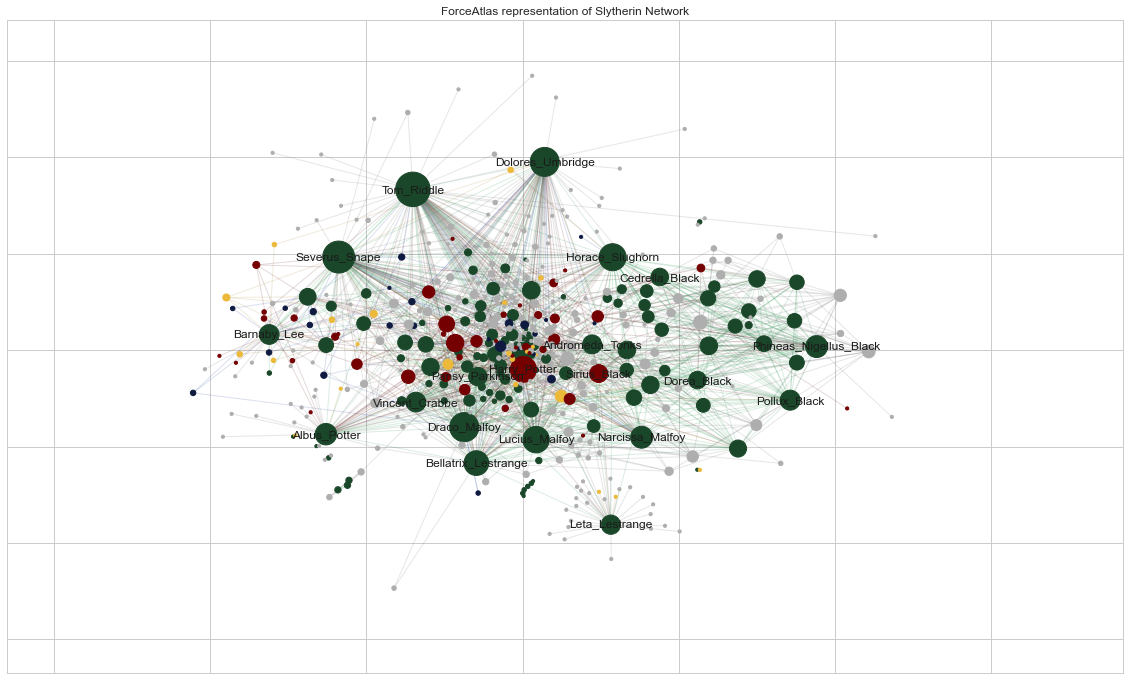

In [63]:
title = "ForceAtlas representation of Slytherin Network"
plotGraph(slyth, title=title, withLabels=True, numLabels=20)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:49<00:00, 40.14it/s]


BarnesHut Approximation  took  3.14  seconds
Repulsion forces  took  45.45  seconds
Gravitational forces  took  0.14  seconds
Attraction forces  took  0.10  seconds
AdjustSpeedAndApplyForces step  took  0.45  seconds


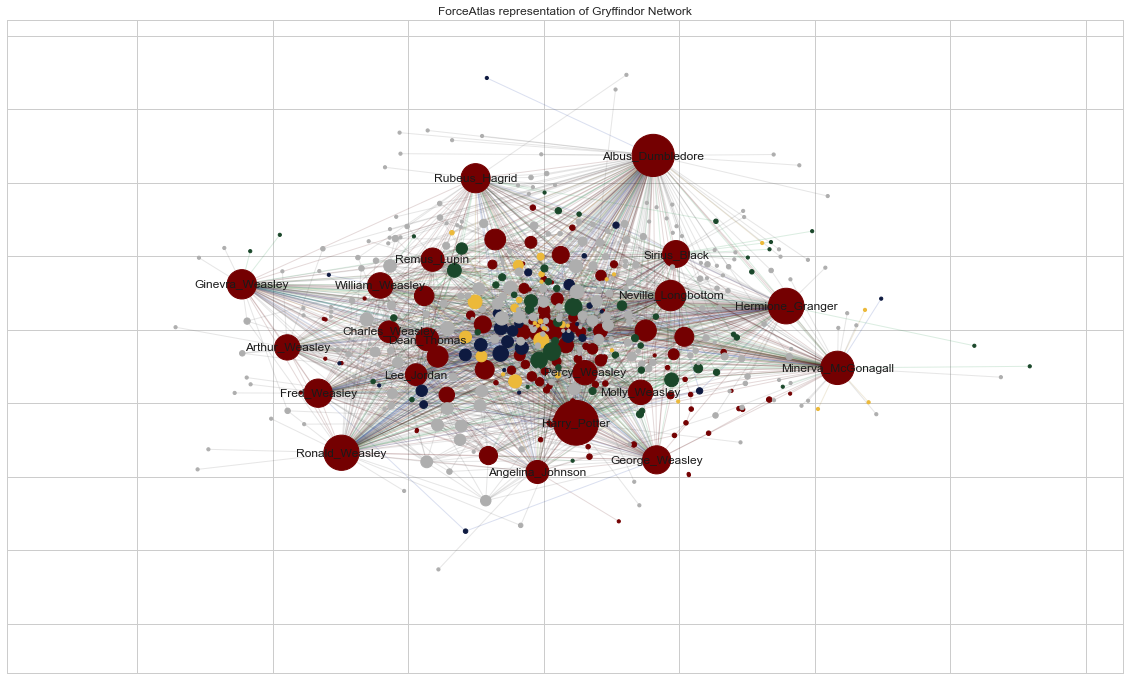

In [64]:
title = "ForceAtlas representation of Gryffindor Network"
plotGraph(gryf, title=title, withLabels=True, numLabels=20)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:21<00:00, 91.26it/s]


BarnesHut Approximation  took  1.81  seconds
Repulsion forces  took  19.41  seconds
Gravitational forces  took  0.07  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.29  seconds


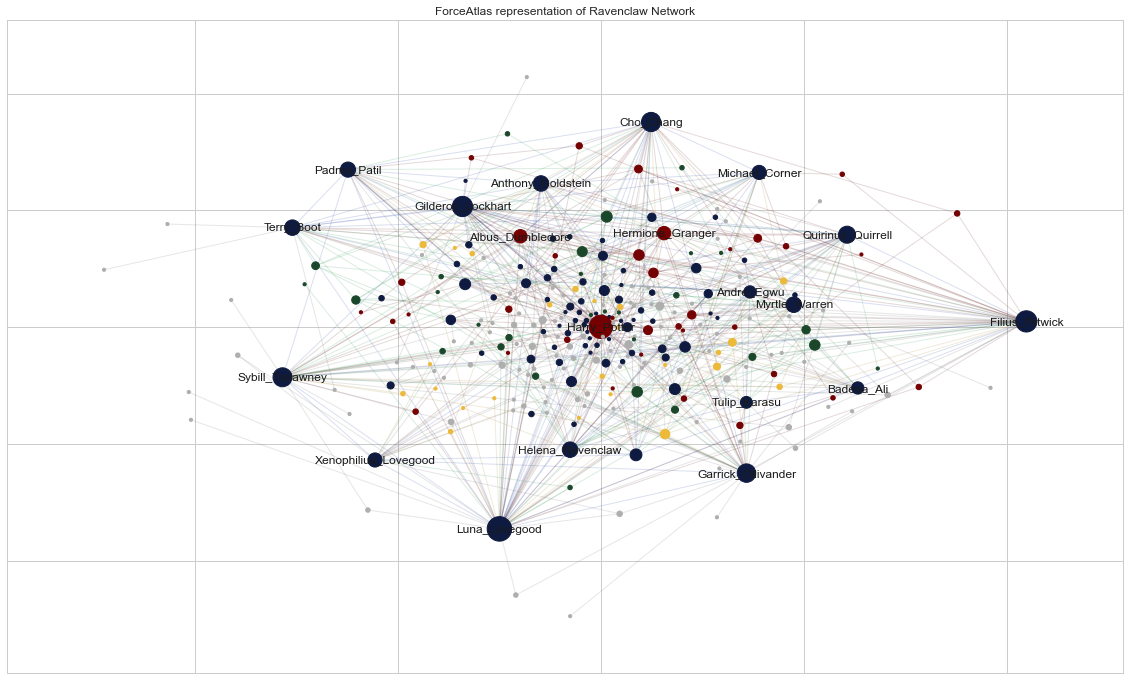

In [65]:
title = "ForceAtlas representation of Ravenclaw Network"
plotGraph(raven, title=title, withLabels=True, numLabels=20)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:25<00:00, 78.16it/s]


BarnesHut Approximation  took  1.94  seconds
Repulsion forces  took  22.88  seconds
Gravitational forces  took  0.09  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.31  seconds


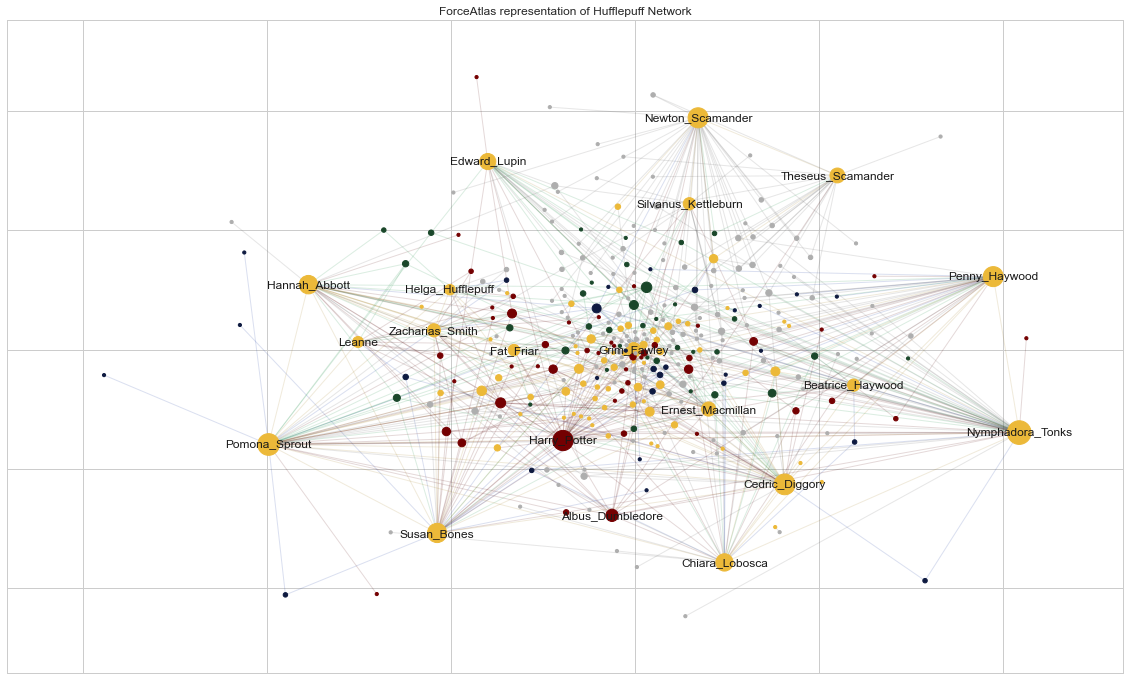

In [66]:
title = "ForceAtlas representation of Hufflepuff Network"
plotGraph(huff, title=title, withLabels=True, numLabels=20)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [05:31<00:00,  6.03it/s]


BarnesHut Approximation  took  31.22  seconds
Repulsion forces  took  295.68  seconds
Gravitational forces  took  0.44  seconds
Attraction forces  took  0.23  seconds
AdjustSpeedAndApplyForces step  took  1.84  seconds


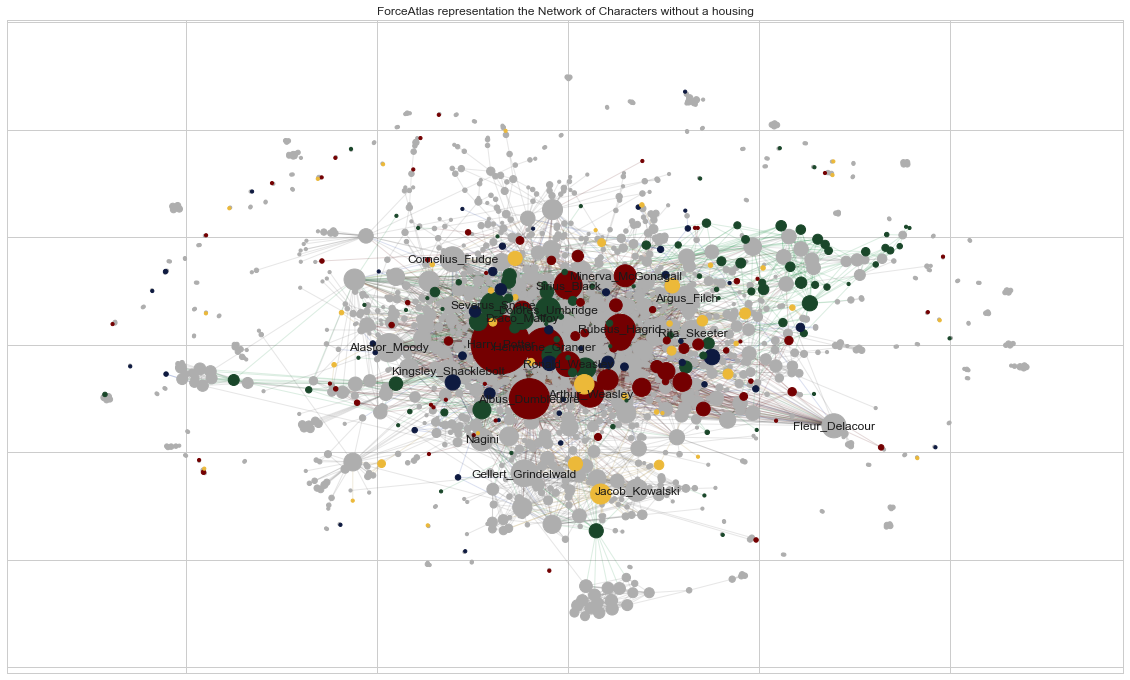

In [67]:
title = "ForceAtlas representation the Network of Characters without a housing"
plotGraph(none, title=title, withLabels=True, numLabels=20)

## Other

In [68]:
def findCommunities(G):
    im = Infomap("--two-level --directed")
    
    # Add links from network
    mapping = im.add_networkx_graph(G)

    # for e in G.edges():
    #     im.addLink(*e)
    
    # Run algorightm
    im.run();
    print(f"Found {im.num_top_modules} communities with codelength: {im.codelength}")

    # Find communities
    communities = {}
    for node in im.tree:
      if node.is_leaf:
        # Get hero from mapping
        i = mapping[node.node_id]
        communities[i] = node.module_id

    #Add attribute to retrieve later
    nx.set_node_attributes(G, communities, "community")
    return communities

In [69]:
ug = G.to_undirected()

# Add communities to network node attribute
findCommunities(ug)

# Create subgraph with consisting only of characters in the largest 10 communiesties 
nodes_coms = {n: attr for n,attr in ug.nodes(data=True) if attr['community'] <= 10}
g_coms = ug.subgraph(nodes_coms)

Found 1069 communities with codelength: 6.579741960518378


In [70]:
# Recreate new Atlas for communities 
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=800.0,
                        strongGravityMode=False,
                        gravity=750,

                        # Log
                        verbose=True)

c_positions = forceatlas2.forceatlas2_networkx_layout(g_coms, pos=None, iterations=2000)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:36<00:00, 55.29it/s]

BarnesHut Approximation  took  5.24  seconds
Repulsion forces  took  29.45  seconds
Gravitational forces  took  0.14  seconds
Attraction forces  took  0.19  seconds
AdjustSpeedAndApplyForces step  took  0.60  seconds


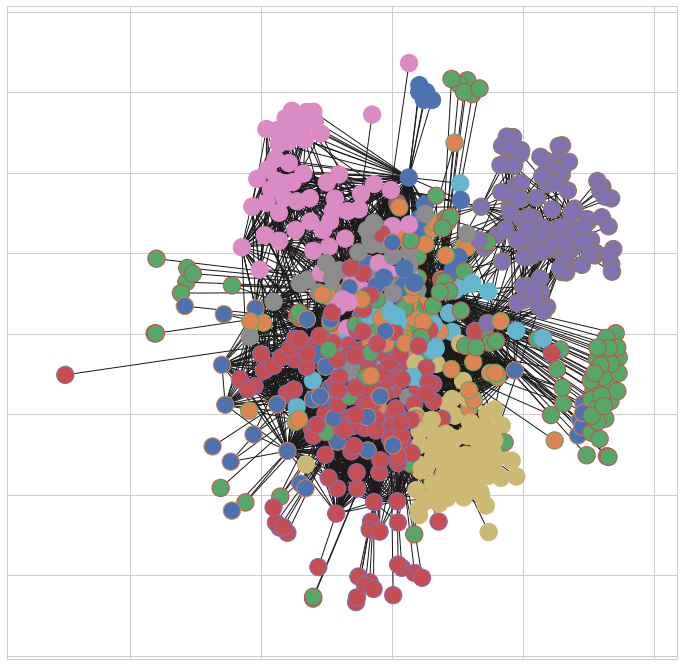

In [72]:
plt.figure(1,figsize=(12,12)) 

attrs = nx.get_node_attributes(g_coms, 'community')

# community ids
communities = [v for k,v in attrs.items()]
numCommunities = max(communities) + 1

# Get colormap
c = sns.color_palette(None, 10)
cmapLight = colors.ListedColormap(c, 'indexed', numCommunities)
cmapDark = colors.ListedColormap(c, 'indexed', numCommunities)

# Draw edges
nx.draw_networkx_edges(g_coms, pos=c_positions)
# Draw nodes
nodeCollection = nx.draw_networkx_nodes(g_coms,
    pos = c_positions,
    node_color = communities,
    cmap = cmapLight
)
# Set node border color to the darker shade
darkColors = [cmapDark(v) for v in communities]
nodeCollection.set_edgecolor(darkColors)

# Draw node labels
# for n in g_coms.nodes():
#     plt.annotate(n,
#         xy = c_positions[n],
#         textcoords = 'offset points',
#         horizontalalignment = 'center',
#         verticalalignment = 'center',
#         xytext = [0, 0],
#         color = cmapDark(attrs[n])
#     )

plt.show()